In [1]:
import sys
sys.path.append('..')

from deepgraph.utils.logging import log
from deepgraph.utils.common import batch_parallel, ConfigMixin, shuffle_in_unison_inplace, pickle_dump
from deepgraph.utils.image import batch_pad_mirror, rotate_transformer_scalar_float32, rotate_transformer_rgb_uint8
from deepgraph.constants import *
from deepgraph.conf import rng
from deepgraph.nn.core import Dropout

from deepgraph.pipeline import *

Using gpu device 0: GeForce GTX TITAN X (CNMeM is enabled with initial size: 85.0% of memory, CuDNN 3007)




  _____                _____                 _
 |  _  \              |  __ \               | |
 | | | |___  ___ _ __ | |  \/_ __ __ _ _ __ | |__
 | | | / _ \/ _ \ '_ \| | __| '__/ _` | '_ \| '_ \
 | |/ /  __/  __/ |_) | |_\ \ | | (_| | |_) | | | |
 |___/ \___|\___| .__/ \____/_|  \__,_| .__/|_| |_|
                | |                   | |
                |_|                   |_|


Available on GitHub: https://github.com/sebastian-schlecht/deepgraph



In [2]:
import math
class Transformer(Processor):
    """
    Apply online random augmentation.
    """
    def __init__(self, name, shapes, config, buffer_size=10):
        super(Transformer, self).__init__(name, shapes, config, buffer_size)
        self.mean = None

    def init(self):
        if self.conf("mean_file") is not None:
            self.mean = np.load(self.conf("mean_file"))
        else:
            log("Transformer - No mean file specified.", LOG_LEVEL_WARNING)

    def process(self):
        packet = self.pull()
        # Return if no data is there
        if not packet:
            return False
        # Unpack
        data, label = packet.data
        # Do processing
        log("Transformer - Processing data", LOG_LEVEL_VERBOSE)
        i_h = 228
        i_w = 304

        d_h = 228
        d_w = 304

        start = time.time()
        # Mean
        if packet.phase == PHASE_TRAIN or packet.phase == PHASE_VAL:
            data = data.astype(np.float32)
            if self.mean is not None:
                for idx in range(data.shape[0]):
                    # Subtract mean
                    data[idx] = data[idx] - self.mean.astype(np.float32)
            if self.conf("offset") is not None:
                label -= self.conf("offset")

        if packet.phase == PHASE_TRAIN:
            # Do elementwise operations

            data_old = data
            label_old = label
            data = np.zeros((data_old.shape[0], data_old.shape[1], i_h, i_w), dtype=np.float32)
            label = np.zeros((label_old.shape[0], d_h, d_w), dtype=np.float32)
            for idx in range(data.shape[0]):
                # Rotate
                # We rotate before cropping to be able to get filled corners
                # Maybe even adjust the border after rotating
                deg = np.random.randint(-5,6)
                # Operate on old data. Careful - data is already in float so we need to normalize and rescale afterwards
                # data_old[idx] = 255. * rotate_transformer_rgb_uint8(data_old[idx] * 0.003921568627, deg).astype(np.float32)
                # label_old[idx] = rotate_transformer_scalar_float32(label_old[idx], deg)
                
                # Take care of any empty areas, we crop on a smaller surface depending on the angle
                # TODO Remove this once loss supports masking
                shift = 0 #np.tan((deg/180.) * math.pi)
                # Random crops
                cy = rng.randint(data_old.shape[2] - d_h - shift, size=1)
                cx = rng.randint(data_old.shape[3] - d_w - shift, size=1)

                data[idx] = data_old[idx, :, cy:cy+i_h, cx:cx+i_w]
                label[idx] = label_old[idx, cy:cy+d_h, cx:cx+d_w]

                # Flip horizontally with probability 0.5
                p = rng.randint(2)
                if p > 0:
                    data[idx] = data[idx, :, :, ::-1]
                    label[idx] = label[idx, :, ::-1]

                # RGB we mult with a random value between 0.8 and 1.2
                r = rng.randint(80,121) / 100.
                g = rng.randint(80,121) / 100.
                b = rng.randint(80,121) / 100.
                data[idx, 0] = data[idx, 0] * r
                data[idx, 1] = data[idx, 1] * g
                data[idx, 2] = data[idx, 2] * b

            # Shuffle
            data, label = shuffle_in_unison_inplace(data, label)
        elif packet.phase == PHASE_VAL:
            # Center crop
            cy = (data.shape[2] - i_h) // 2
            cx = (data.shape[3] - i_w) // 2
            data = data[:, :, cy:cy+i_h, cx:cx+i_w]
            label = label[:, cy:cy+d_h, cx:cx+d_w]
        end = time.time()
        log("Transformer - Processing took " + str(end - start) + " seconds.", LOG_LEVEL_VERBOSE)
        # Try to push into queue as long as thread should not terminate
        self.push(Packet(identifier=packet.id, phase=packet.phase, num=2, data=(data, label)))
        return True

    def setup_defaults(self):
        super(Transformer, self).setup_defaults()
        self.conf_default("mean_file", None)
        self.conf_default("offset", None)

In [ ]:
from theano.tensor.nnet import relu

from deepgraph.graph import *
from deepgraph.nn.core import *
from deepgraph.nn.conv import *
from deepgraph.nn.loss import *
from deepgraph.solver import *

from deepgraph.pipeline import Optimizer, H5DBLoader, Pipeline


def build_graph():
    graph = Graph("depth_predictor")

    data            = Data(graph, "data", T.ftensor4, shape=(-1, 3, 228, 304))
    label           = Data(graph, "label", T.ftensor3, shape=(-1, 1, 228, 304), config={
        "phase": PHASE_TRAIN
    })
    pool_label = Pool(graph, "pool_label", config={
        "kernel": (2, 2),
        "mode": "average_exc_pad",
        "phase": PHASE_TRAIN
    })
    conv_0     = Conv2D(graph, "conv_0", config={
            "channels": 96,
            "kernel": (11, 11),
            "subsample": (4, 4),
            "activation": relu,
            "learning_rate": 0
        }
    )
    pool_0 = Pool(graph, "pool_0", config={
        "kernel": (3, 3),
        "stride": (2, 2)
    })
    lrn_0           = LRN(graph, "lrn_0")
    conv_1   = Conv2D(
        graph,
        "conv_1",
        config={
            "channels": 256,
            "kernel": (5, 5),
            "border_mode": 2,
            "activation": relu,
            "learning_rate": 0
        }
    )
    pool_1 = Pool(graph, "pool_1", config={
        "kernel": (3, 3),
        "stride": (2, 2)
    })
    lrn_1           = LRN(graph, "lrn_1")
    conv_2          = Conv2D(
        graph,
        "conv_2",
        config={
            "channels": 384,
            "kernel": (3, 3),
            "border_mode": 1,
            "activation": relu,
            "learning_rate": 0
        }
    )
    conv_3          = Conv2D(
        graph,
        "conv_3",
        config={
            "channels": 384,
            "kernel": (3, 3),
            "border_mode": 1,
            "activation": relu,
            "learning_rate": 0
        }
     )
    conv_4          = Conv2D(
        graph,
        "conv_4",
        config={
            "channels": 256,
            "kernel": (3, 3),
            "border_mode": 1,
            "activation": relu,
            "learning_rate": 0
        }
    )
    pool_4 = Pool(graph, "pool_4", config={
        "kernel": (3, 3),
        "stride": (2, 2)
    })
    flatten         = Flatten(graph, "flatten", config={
        "dims": 2
    })
    hidden_0        = Dense(graph, "fc_0", config={
        "out": 4096,
        "activation": None,
        "learning_rate": 0
    })
    dp_0            = Dropout(graph, "dp_0")
    hidden_1        = Dense(graph, "fc_1", config={
        "out": 4332,
        "activation": None,
        "learning_rate": 0
    })
    rs              = Reshape(graph, "reshape_0", config={
        "shape": (-1, 1, 57, 76),
        "is_output": True
    })
    
    """
    Scale 2
    """
    
    # Upsamples from scale 1
    up_1 = Upsample(graph, "up_1", config={
        "kernel": (2, 2)
    })
    up_2 = Upsample(graph, "up_2", config={
        "kernel": (4, 4)
    })
    # Convolve input again, smaller kernels
    concat_2_1 = Concatenate(graph, "concat_2_1", config={
            "axis": 1
     })
    conv_2_1 = Conv2D(graph, "conv_2_1", config={
        "channels": 63,
        "kernel": (3, 3),
        "border_mode": 1,
        "activation": relu
    })
    conv_2_2 = Conv2D(graph, "conv_2_2", config={
        "channels": 64,
        "kernel": (3, 3),
        "border_mode": 1,
        "activation": relu
    })
    pool_2_2 = Pool(graph, "pool_2_2", config={
        "kernel": (2, 2)  
        })
    
    concat_2_2 = Concatenate(graph, "concat_2_2", config={
            "axis": 1
     })
    
    conv_2_3 = Conv2D(graph, "conv_2_3", config={
        "channels": 63,
        "kernel": (3, 3),
        "border_mode": 1,
        "activation": relu
    })
    conv_2_4 = Conv2D(graph, "conv_2_4", config={
        "channels": 64,
        "kernel": (3, 3),
        "border_mode": 1,
        "activation": relu
    })
    conv_2_5 = Conv2D(graph, "conv_2_5", config={
        "channels": 1,
        "kernel": (3, 3),
        "border_mode": 1,
        "activation": relu
    })
    
    

    loss            = EuclideanLoss(graph, "loss")

    error = MSE(graph, "mse", config={
        "root": True,
        "is_output": True,
        "phase": PHASE_TRAIN
    })

    # Connect
    data.connect(conv_0)
    conv_0.connect(pool_0)
    pool_0.connect(lrn_0)
    lrn_0.connect(conv_1)
    conv_1.connect(pool_1)
    pool_1.connect(lrn_1)
    lrn_1.connect(conv_2)
    conv_2.connect(conv_3)
    conv_3.connect(conv_4)
    conv_4.connect(pool_4)
    pool_4.connect(flatten)
    flatten.connect(hidden_0)
    hidden_0.connect(dp_0)
    dp_0.connect(hidden_1)
    hidden_1.connect(rs)
    rs.connect(up_1)
    rs.connect(up_2)
    
    data.connect(conv_2_1)
    conv_2_1.connect(concat_2_1)
    up_2.connect(concat_2_1)
    concat_2_1.connect(conv_2_2)
    conv_2_2.connect(pool_2_2)
    pool_2_2.connect(conv_2_3)
    conv_2_3.connect(concat_2_2)
    up_1.connect(concat_2_2)
    concat_2_2.connect(conv_2_4)
    conv_2_4.connect(conv_2_5)
    conv_2_5.connect(loss)
    conv_2_5.connect(error)
    
    
    label.connect(pool_label)
    pool_label.connect(loss)
    pool_label.connect(error)

    return graph

In [ ]:
if __name__ == "__main__":

    batch_size = 32
    chunk_size = 10*batch_size
    transfer_shape = ((chunk_size, 3, 228, 304), (chunk_size, 228, 304))

    g = build_graph()

    # Build the training pipeline
    db_loader = H5DBLoader("db", ((chunk_size, 3, 480, 640), (chunk_size, 1, 480, 640)), config={
        "db": '/home/ga29mix/nashome/data/nyu_depth_v2_combined_50.hdf5',
        # "db": '../data/nyu_depth_unet_large.hdf5',
        "key_data": "images",
        "key_label": "depths",
        "chunk_size": chunk_size
    })
    transformer = Transformer("tr", transfer_shape, config={
        # Measured for the data-set
        # "offset": 2.7321029
        "mean_file": "/home/ga29mix/nashome/data/nyu_depth_v2_combined_50.npy"
    })
    optimizer = Optimizer("opt", g, transfer_shape, config={
        "batch_size":  batch_size,
        "chunk_size": chunk_size,
        "learning_rate": 0.01,
        "momentum": 0.9,
        "weight_decay": 0.0005,
        "print_freq": 100,
        "save_freq": 20000,
        "weights": "../data/alexnet_combined_phase2_iter_23000.zip",
        "save_prefix": "../data/alexnet_scale_2"
    })

    p = Pipeline(config={
        "validation_frequency": 50,
        "cycles": 6500
    })
    p.add(db_loader)
    p.add(transformer)
    p.add(optimizer)
    p.run()





[2016-04-10 19:57:33] INFO: Pipeline - Starting computation
[2016-04-10 19:57:36] INFO: Graph - Loading parameters from file '../data/alexnet_combined_phase2_iter_23000.zip'
[2016-04-10 19:57:36] INFO: Graph - Setting up graph
[2016-04-10 19:57:36] INFO: Node - data has shape (-1, 3, 228, 304)
[2016-04-10 19:57:36] INFO: Node - label has shape (-1, 1, 228, 304)
[2016-04-10 19:57:36] INFO: Node - conv_0 has shape (-1, 96, 55, 74)
[2016-04-10 19:57:36] INFO: Node - conv_2_1 has shape (-1, 63, 228, 304)
[2016-04-10 19:57:36] INFO: Node - pool_label has shape (-1, 1, 114, 152)
[2016-04-10 19:57:36] INFO: Node - pool_0 has shape (-1, 96, 27, 36)
[2016-04-10 19:57:36] INFO: Node - lrn_0 has shape (-1, 96, 27, 36)
[2016-04-10 19:57:36] INFO: Node - conv_1 has shape (-1, 256, 27, 36)
[2016-04-10 19:57:36] INFO: Node - pool_1 has shape (-1, 256, 13, 17)
[2016-04-10 19:57:36] INFO: Node - lrn_1 has shape (-1, 256, 13, 17)
[2016-04-10 19:57:36] INFO: Node - conv_2 has shape (-1, 384, 13, 17)
[201

In [3]:
g = build_graph()
g.load_weights("../data/alexnet_combined_phase2_iter_23000.zip")
g.compile()

[2016-04-10 18:58:08] INFO: Graph - Loading parameters from file '../data/alexnet_combined_phase2_iter_23000.zip'
[2016-04-10 18:58:08] INFO: Graph - Setting up graph
[2016-04-10 18:58:08] INFO: Node - data has shape (-1, 3, 228, 304)
[2016-04-10 18:58:08] INFO: Node - label has shape (-1, 1, 228, 304)
[2016-04-10 18:58:08] INFO: Node - conv_0 has shape (-1, 96, 55, 74)
[2016-04-10 18:58:08] INFO: Node - pool_label has shape (-1, 1, 57, 76)
[2016-04-10 18:58:08] INFO: Node - pool_0 has shape (-1, 96, 27, 36)
[2016-04-10 18:58:08] INFO: Node - lrn_0 has shape (-1, 96, 27, 36)
[2016-04-10 18:58:08] INFO: Node - conv_1 has shape (-1, 256, 27, 36)
[2016-04-10 18:58:08] INFO: Node - pool_1 has shape (-1, 256, 13, 17)
[2016-04-10 18:58:08] INFO: Node - lrn_1 has shape (-1, 256, 13, 17)
[2016-04-10 18:58:08] INFO: Node - conv_2 has shape (-1, 384, 13, 17)
[2016-04-10 18:58:08] INFO: Node - conv_3 has shape (-1, 384, 13, 17)
[2016-04-10 18:58:08] INFO: Node - conv_4 has shape (-1, 256, 13, 17)

In [11]:
import h5py, numpy as np

f = h5py.File("/home/ga29mix/nashome/data/nyu_depth_v2_combined_50.hdf5")

b = int(f["images"].shape[0] * 0.9)
images = np.array(f["images"][b:])
depths = np.array(f["depths"][b:])
print images.shape
mean = np.load("/home/ga29mix/nashome/data/nyu_depth_v2_combined_50.npy")

w = 304
h = 228

(374, 3, 240, 320)


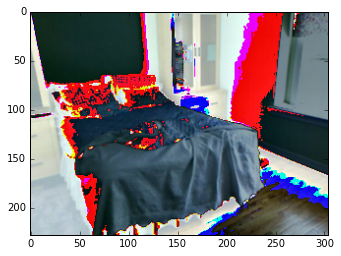

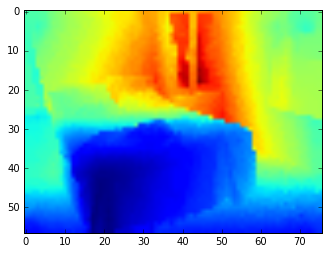

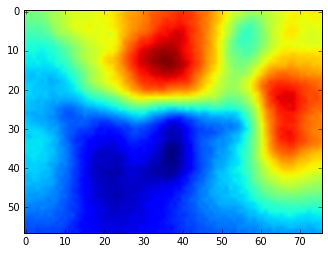

RMSE: 0.712121


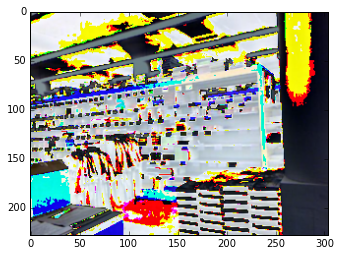

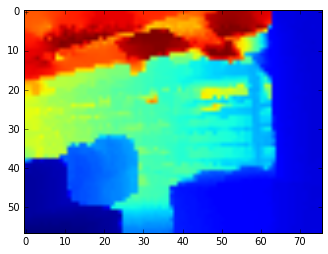

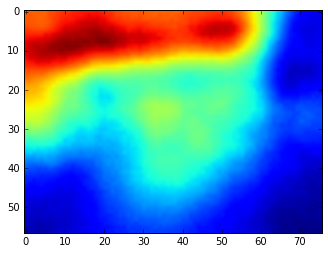

RMSE: 1.01947


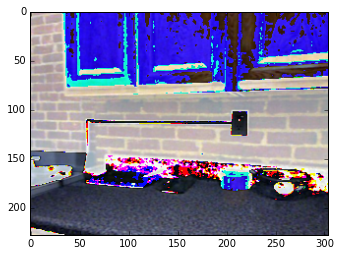

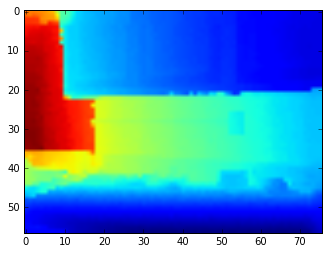

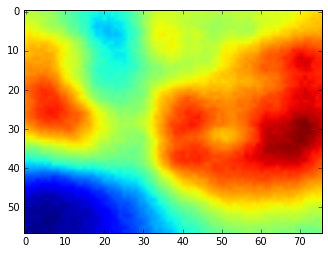

RMSE: 0.377822


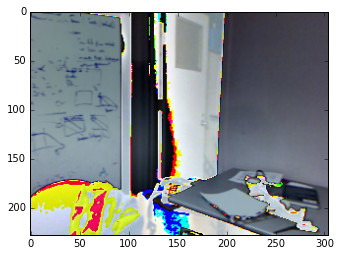

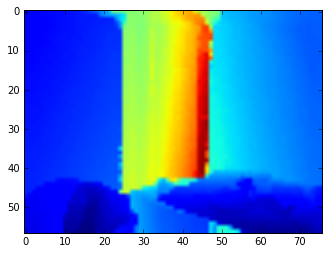

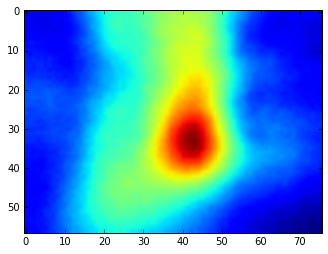

RMSE: 0.361294
Accumulated RMSE: 0.682446


In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
plot = True
idx = 0
diffs = []
for image in images[0:20]:
    tmp = image.astype(np.float32)
    tmp -= mean
    cy = (tmp.shape[1] - h) // 2
    cx = (tmp.shape[2] - w) // 2
    crop = tmp[:,cy:cy+h, cx:cx+w]
    res = g.infer([crop.reshape((1,3,228,304))])["reshape_0"]
    res = res.squeeze()
    depth = depths[idx][cy:cy + h, cx:cx + w]
    depth = depth[::4,::4]
    if plot and idx % 5 == 0:
        
        plt.imshow(crop.transpose((1,2,0)).astype(np.uint8))
        plt.show()
        plt.imshow(depth)
        plt.show()
        plt.imshow(res)
        plt.show()
        print "RMSE: " + str(np.sqrt(np.mean((res-depth)**2)))
    diffs.append(res - depth)
    
    idx += 1
    
diffs = np.array(diffs)
rmse = np.sqrt(np.mean(diffs ** 2))
print "Accumulated RMSE: " + str(rmse)
    